#**Red neuronal convolucional para la clasificación de imágenes entre Bart y Homero**

##**Realizado por:**

*   Luis Miguel Ossa - A00369982
*   Keren López Córdoba - A00368902

##**Sobre el dataset**
Son 269 imágenes con las caras y los cuerpos de Homer y Bart, las imágenes ya tienen los nombres, lo que facilita el tratamiento y el entrenamiento de la red neuronal.

![](https://storage.googleapis.com/kaggle-datasets-images/1761725/2876405/e1c4a37080cd7d46e92e2b0d61627a44/dataset-cover.jpg?t=2021-12-02-02-17-49)

##**Importar librerias**

1. **Importación de módulos y bibliotecas**

  Se importan las bibliotecas necesarias, como **google.colab**, **Path** de **pathlib**, **cv2** para procesamiento de imágenes, **numpy** para operaciones numéricas, y **pandas** para manipulación de datos.

2. **División de datos**

  Se utiliza la función **train_test_split** de la biblioteca **sklearn** para dividir los datos en conjuntos de entrenamiento y prueba, una práctica común en la evaluación de modelos.

3. **Flatten de imágenes**

  Se importa **keras** de **tensorflow** para aplanar las imágenes, indicando una posible preparación de datos para modelos de aprendizaje profundo, especialmente redes neuronales convolucionales.

4. **Visualización de datos**

  Se importa **matplotlib.pyplot** para la visualización de datos, sugiriendo que el código puede incluir representación gráfica de resultados, como imágenes o métricas de entrenamiento.

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
# Importa la funcionalidad de carga de archivos desde Google Colab.
from google.colab import files

# Importa módulos para operaciones y manipulación de datos.
from pathlib import Path  # Para manipulación de rutas de archivos y directorios.
import cv2  # Para procesamiento de imágenes.
import numpy as np  # Para operaciones numéricas.
import pandas as pd  # Para manipulación de datos tabulares.
import seaborn as sns

# Importa la función para dividir datos en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

# Importa la biblioteca para visualización de datos.
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation, experimental
import tensorflow as tf

In [ ]:
# Monta Google Drive en Colab.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##**Procesamiento de datos**

In [ ]:
# Nuevo tamaño para las imágenes.
width, height = 64, 64

In [ ]:
# Inicializa las listas 'classification' y 'images'.
# 'imagesPath' apunta al directorio de imágenes en Google Drive.classification = []
images = []
classification = []
imagesPath = Path('/content/drive/MyDrive/Colab Notebooks/test_datasets/homer_bart_1')

# Se itera sobre los archivos en 'imagesPath' para clasificarlos (1 para 'homer', 0 para 'bart').
for pathImage in imagesPath.iterdir():
    if pathImage.name.startswith('h'):
        classification.append(1)
    else:
        classification.append(0)

    # Lee, redimensiona y agrega las imágenes a la lista 'images'.
    image = cv2.imread(str(pathImage))
    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)


In [ ]:
#Convertir las listas de clasificación e imagenes en arreglos de numpy.
classification_array = np.array(classification)
images_array = np.array(images)

In [ ]:
#Escalar el arreglo de imágenes para que todos sus valores queden entre 0 y 1.
images_array = images_array / 255.0

In [ ]:
images_array[0].shape

(64, 64, 3)

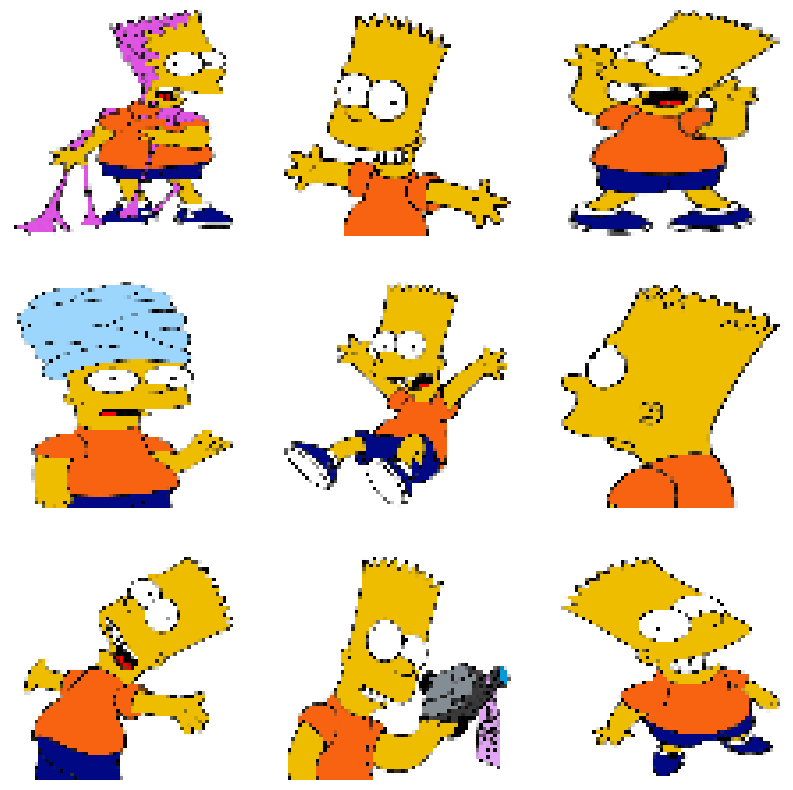

In [ ]:
# Crea un gráfico de 3x3 para visualizar las primeras 9 imágenes en 'images_array'.
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images_array[i])
    plt.axis(False)

## **Data split (sets 80/20)**

In [ ]:
# Divide los conjuntos de datos en entrenamiento y prueba utilizando 'train_test_split'.
X_train, X_test, y_train, y_test = train_test_split(images_array, classification_array, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(215, 64, 64, 3)

In [ ]:
X_test.shape

(54, 64, 64, 3)

In [ ]:
y_train.shape

(215,)

In [ ]:
y_test.shape

(54,)

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print ("y_train shape: " + str(y_train.shape))
print ("y_test shape: " + str(y_test.shape))

y_train shape: (215, 1)
y_test shape: (54, 1)


##**Data Augmentation**

In [ ]:
data_augmentation = Sequential([experimental.preprocessing.RandomRotation(0.2),
                                experimental.preprocessing.RandomZoom(0.1),
                                experimental.preprocessing.RandomFlip("horizontal")])

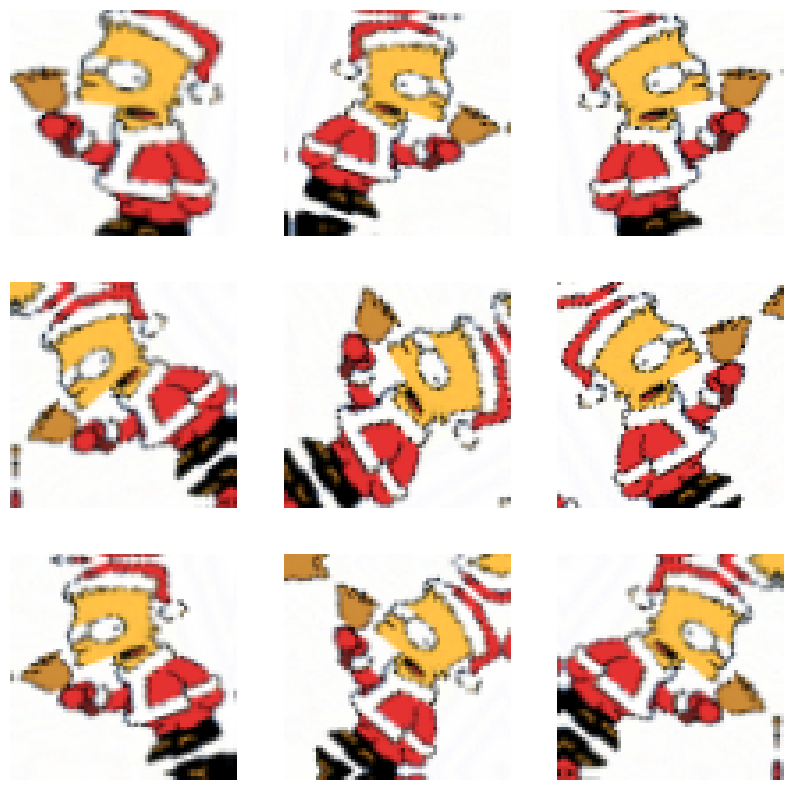

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    data_augmented = data_augmentation(X_train[0])
    plt.imshow(data_augmented)
    plt.axis(False)

##**Modelado de la red convolucional usando la librería de Tensorflow**

La función keras.Sequential de TensorFlow se utiliza para construir modelos de redes neuronales secuenciales, donde las capas se apilan una encima de la otra en orden. Los parámetros de la función son las capas que se agregarán al modelo y demás atributos que se explican a continuación:

* **Capas:** Los argumentos pasados a keras.Sequential son las capas que se incluirán en el modelo. Cada capa se especifica como un elemento en la lista. En el ejemplo proporcionado, las capas incluidas son:

  * **Capas de agrupación máxima (MaxPooling2D):** Realizan el submuestreo de las características extraídas por las capas convolucionales.

  * **Capas completamente conectadas (Dense):** Capas de neuronas totalmente conectadas.
  * **Capas convolucionales (Conv2D):** Realizan operaciones de convolución en las imágenes.

* **data_augmentation:** Una secuencia de aumentación de datos definida previamente.

* **input_shape:** En la primera capa Conv2D, se especifica input_shape=(128, 128, 3), indicando que las imágenes de entrada son de tamaño 128x128 píxeles con 3 canales de color (RGB).

* **activation:** Se especifica la función de activación para las capas convolucionales y completamente conectadas. En este caso, se utiliza "relu" para las capas convolucionales y la primera capa completamente conectada, y "sigmoid" en la última capa para la clasificación binaria.

* **kernel_size:** Indica el tamaño de la ventana de convolución.

* **strides:** Especifica el paso utilizado durante la convolución.

* **padding:** Controla el relleno aplicado a las imágenes durante la convolución.

In [ ]:
model = Sequential([
    data_augmentation,
    Conv2D(200,input_shape=(64,64,3),activation="relu",kernel_size=3,strides=2,padding="same"),
    MaxPooling2D(2),
    Conv2D(800,activation="relu",kernel_size=3,strides=2,padding="same"),
    MaxPooling2D(),

    Flatten(),
    Dense(1,activation="sigmoid")
])

##**Compilación del modelo (model.compile):**

* **loss="binary_crossentropy":** La función de pérdida utilizada para problemas de clasificación binaria. Mide la discrepancia entre las predicciones y las etiquetas reales.
* **metrics=["accuracy"]:** Evalúa el rendimiento del modelo utilizando la métrica de precisión durante el entrenamiento y la evaluación.

* **optimizer=keras.optimizers.Adam(learning_rate=0.01):** Utiliza el optimizador Adam con una tasa de aprendizaje de 0.01 para ajustar los pesos del modelo durante el entrenamiento.

##**Parada temprana (keras.callbacks.EarlyStopping):**

* **patience=10:** Detiene el entrenamiento si la métrica no mejora durante 20 épocas consecutivas. La parada temprana ayuda a prevenir el sobreajuste y a mejorar la eficiencia del entrenamiento deteniéndolo antes si no se observa mejora.

In [ ]:
# Configura el modelo para el entrenamiento.
model.compile(loss="binary_crossentropy",metrics=["accuracy"],optimizer=Adam(learning_rate=0.01))
# Establece la parada temprana durante el entrenamiento.
early_stop = EarlyStopping(patience=10)

* Se realiza el entrenamiento del modelo utilizando el conjunto de entrenamiento (X_train y y_train).

* La métrica de rendimiento se evalúa en el conjunto de prueba (X_test y y_test).

* El entrenamiento se realiza durante un máximo de 20 épocas, pero la parada temprana definida por early_stop puede detener el entrenamiento antes si no se observa mejora en la métrica de validación después de un cierto número de épocas.

* El historial del entrenamiento se almacena en la variable history para su posterior análisis y visualización.

In [ ]:
# Entrena el modelo utilizando el conjunto de entrenamiento (X_train, y_train).
history = model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=20, batch_size=10, callbacks=early_stop)

Epoch 1/20
22/22 [==============================] - 5s 192ms/step - loss: 1.2852 - accuracy: 0.6419 - val_loss: 0.9468 - val_accuracy: 0.5741
Epoch 2/20
22/22 [==============================] - 3s 154ms/step - loss: 0.6345 - accuracy: 0.6698 - val_loss: 1.0751 - val_accuracy: 0.6111
Epoch 3/20
22/22 [==============================] - 5s 229ms/step - loss: 0.4721 - accuracy: 0.7907 - val_loss: 0.6133 - val_accuracy: 0.7037
Epoch 4/20
22/22 [==============================] - 4s 163ms/step - loss: 0.4152 - accuracy: 0.8093 - val_loss: 0.5715 - val_accuracy: 0.7778
Epoch 5/20
22/22 [==============================] - 4s 162ms/step - loss: 0.4612 - accuracy: 0.7721 - val_loss: 0.6694 - val_accuracy: 0.7407
Epoch 6/20
22/22 [==============================] - 4s 196ms/step - loss: 0.4693 - accuracy: 0.7860 - val_loss: 0.5110 - val_accuracy: 0.7222
Epoch 7/20
22/22 [==============================] - 4s 189ms/step - loss: 0.4076 - accuracy: 0.8558 - val_loss: 0.3928 - val_accuracy: 0.8148
Epoch 

##**Gráficas**

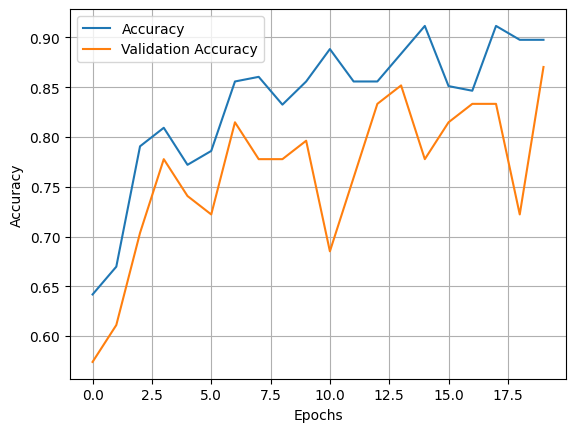

In [ ]:
# Grafica las curvas de precisión (accuracy) y precisión de validación (val_accuracy) a lo largo de las épocas.
history_df = pd.DataFrame(history.history)
plt.plot(history_df.accuracy,label="Accuracy")
plt.plot(history_df.val_accuracy,label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

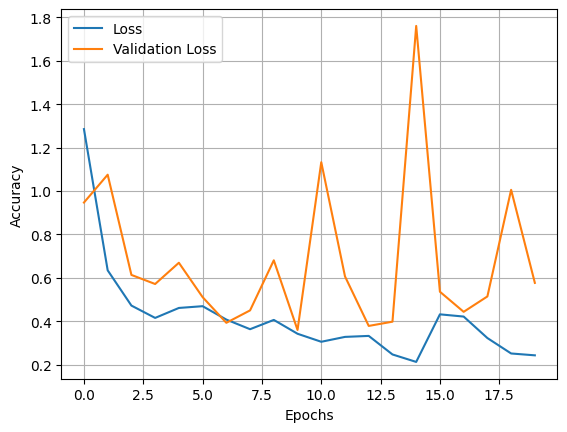

In [ ]:
# Grafica las curvas de pérdida (loss) y pérdida de validación (val_loss) a lo largo de las épocas.
history_df = pd.DataFrame(history.history)
plt.plot(history_df.loss,label="Loss")
plt.plot(history_df.val_loss,label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

##**Predicciones**
* Se realizan predicciones utilizando el modelo entrenado sobre el conjunto de prueba (X_test).

* Luego, convierte las predicciones continuas en etiquetas binarias utilizando un umbral de 0.5. Si la predicción es mayor o igual a 0.5, se asigna el valor 1, de lo contrario, se asigna el valor 0.

* Las predicciones resultantes se almacenan en la lista prediction_label.

In [ ]:
prediction = model.predict(X_test)
prediction_label = []
for i in prediction:
    i = int(i)
    if i >= 0.5:
        prediction_label.append(i)
    else:
        prediction_label.append(i)

prediction = model.predict(X_test)
prediction_label = []
for score in prediction:
    score = float(score)  # Ensure the score is treated as a float
    if score >= 0.5:
        prediction_label.append(1)  # Append 1 for scores greater than or equal to 0.5
    else:
        prediction_label.append(0)  # Append 0 for scores less than 0.5


2/2 [==============================] - 0s 118ms/step


<ipython-input-39-4f854a8f52fc>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(i)


2/2 [==============================] - 0s 135ms/step


<ipython-input-39-4f854a8f52fc>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(score)  # Ensure the score is treated as a float


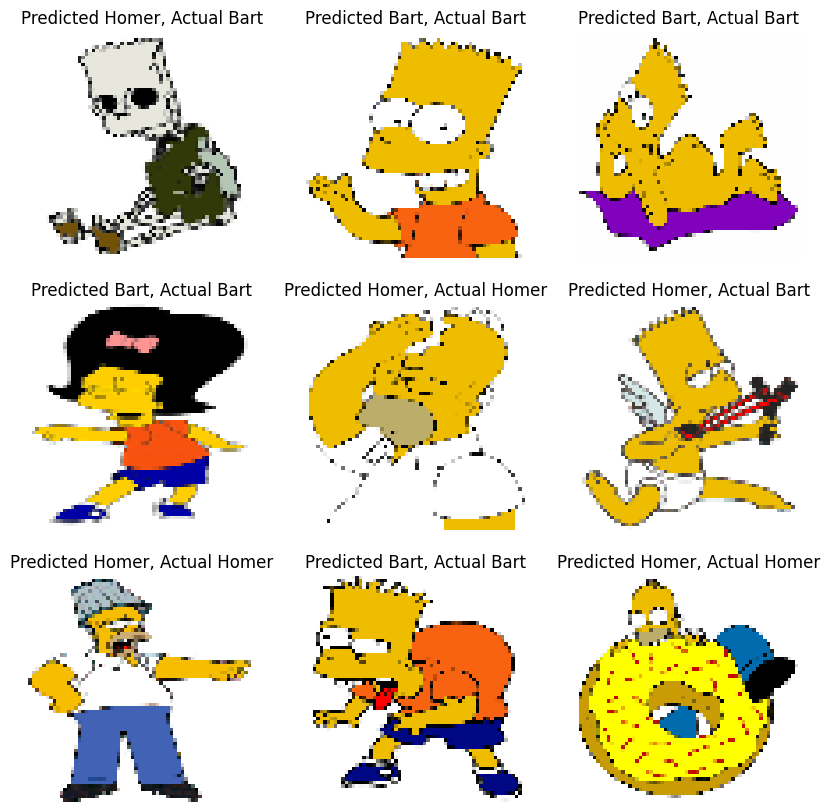

In [ ]:
# Define las etiquetas de clase para la visualización.
class_names = ["Bart", "Homer"]

# Crea un gráfico de 3x3 para visualizar las primeras 9 imágenes del conjunto de prueba y sus predicciones.
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Predicted {class_names[prediction_label[i]]}, Actual {class_names[y_test[i][0]]}")
    plt.axis(False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction_label))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        31
           1       0.83      0.87      0.85        23

    accuracy                           0.87        54
   macro avg       0.87      0.87      0.87        54
weighted avg       0.87      0.87      0.87        54



#Precision

La precisión es una medida que evalúa la exactitud de las predicciones positivas realizadas por el modelo. En este contexto, para la clase 0, la precisión del 90% indica que de todas las muestras que el modelo clasificó como pertenecientes a la clase 0, el 90% de ellas efectivamente eran de esta clase. De manera similar, para la clase 1, la precisión del 83% sugiere que el 83% de las instancias clasificadas como pertenecientes a la clase 1 por el modelo eran genuinamente de esta clase.

#Recall

El recall, también conocido como sensibilidad, mide la capacidad del modelo para identificar correctamente todas las muestras relevantes. En este contexto, el recall del 87% para ambas clases indica que el modelo logró identificar el 87% de todas las instancias verdaderamente pertenecientes a la clase 0 y clase 1, respectivamente.

#F1-score

El puntaje F1 es una métrica que combina tanto la precisión como el recall en una sola medida, ofreciendo así una evaluación más equilibrada del rendimiento del modelo. Para la clase 0, el puntaje F1 del 89% indica un buen equilibrio entre precisión y recall, lo que sugiere que el modelo logra clasificar correctamente la clase 0 de manera consistente. Para la clase 1, el puntaje F1 del 85% también refleja un equilibrio similar entre precisión y recall, lo que sugiere un rendimiento sólido en la clasificación de la clase 1.

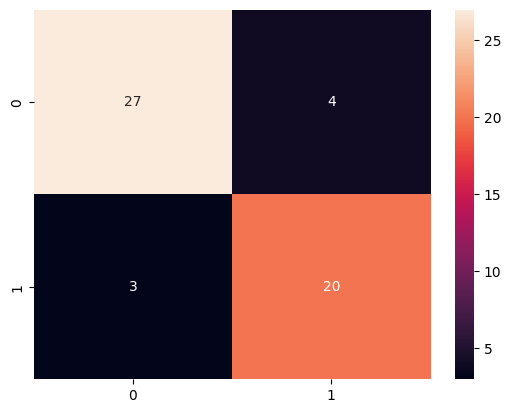

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_label)
sns.heatmap(cm, annot=True);

La matriz de confusión representa el desempeño del modelo de clasificación en la tarea de predecir las clases de un conjunto de datos. En este caso, la matriz de confusión tiene dos filas y dos columnas, correspondientes a las clases 0 y 1.

* La celda (1,1) contiene el valor 27, lo que indica que el modelo clasificó correctamente 27 muestras como pertenecientes a la clase 0.
* La celda (1,2) contiene el valor 4, lo que significa que el modelo clasificó incorrectamente 4 muestras como pertenecientes a la clase 1 cuando en realidad eran de la clase 0.
* La celda (2,1) contiene el valor 3, lo que indica que el modelo clasificó incorrectamente 3 muestras como pertenecientes a la clase 0 cuando en realidad eran de la clase 1.
* La celda (2,2) contiene el valor 20, lo que sugiere que el modelo clasificó correctamente 20 muestras como pertenecientes a la clase 1.

Basándonos en la apreciación de la matriz de confusión, podemos decir que el comportamiento del modelo es bueno. Es importante destacar que dependiendo del contexto del modelo, esta interpretación puede cambiar para mejor o peor.